In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import pandas as pd
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv("combined_df.csv")
#data.head()

In [8]:
train_data = data[data['dataset'] == 'train']
validate_data = data[data['dataset'] == 'validation']
test_data = data[data['dataset'] == 'test']

In [10]:
train_data['success_level'].value_counts()

success_level
Success        3177
Flop           3074
Blockbuster    1929
Name: count, dtype: int64

In [12]:
data['success_level'].value_counts()

success_level
Success        4555
Flop           4385
Blockbuster    2746
Name: count, dtype: int64

In [18]:
#split X and Y data and drop columns unwanted
X_noy =  train_data.drop('success_level', axis=1)
X_without_text_columns = X_noy.select_dtypes(exclude=['object'])
Y = train_data[['success_level']]
#X_without_text_columns.head()
X = X_without_text_columns.drop(['id','revenue','budget_millions','revenue_millions','ordering_x','ordering_y','vote_count','popularity','roi','profit'], axis=1)
X= X.fillna(X.mean())
#X.head()

In [13]:
# def stepwise_selection(X_train, y_train, threshold_in=0.05, threshold_out=0.05):
#     """
#     Perform stepwise regression: Both forward and backward selection.
    
#     X_train : Training dataset with the intercept
#     y_train : Target variable
#     threshold_in : Entry p-value threshold for a feature to enter the model
#     threshold_out : Exit p-value threshold for a feature to be removed
#     """
#     initial_features = X_train.columns.tolist()
#     included = list(initial_features)
#     while True:
#         changed = False
#         # Forward step: Add features that improve the model
#         excluded = list(set(initial_features) - set(included))
#         new_pval = pd.Series(index=excluded)
#         for new_col in excluded:
#             model = sm.Logit(y_train, X_train[included + [new_col]]).fit(disp=False)
#             new_pval[new_col] = model.pvalues[new_col]
#         min_pval = new_pval.min()
#         if min_pval < threshold_in:
#             best_feature = new_pval.idxmin()
#             included.append(best_feature)
#             changed = True

#         # Backward step: Remove features that have a high p-value
#         model = sm.Logit(y_train, X_train[included]).fit(disp=False)
#         pvalues = model.pvalues[1:]  # exclude intercept
#         max_pval = pvalues.max()
#         if max_pval > threshold_out:
#             worst_feature = pvalues.idxmax()
#             included.remove(worst_feature)
#             changed = True
        
#         if not changed:
#             break
#     return included

In [41]:
# selected_features = stepwise_selection(X, Y)
# print(f"Selected features: {selected_features}")

In [21]:
#perform forward feature selection and select the top 10 features
sfs = SequentialFeatureSelector(LogisticRegression(),
                                k_features=10,
                                forward=True,
                                scoring='accuracy',
                               # max_iter=100,
                                cv=5)
selected_features = sfs.fit(X, Y)
print(selected_features.k_feature_names_)

('adult', 'Documentary', 'TV Movie', 'production_companies_New Line Cinema', 'production_companies_Walt Disney Pictures', 'Mapped Value_Africa', 'Mapped Value_Australia', 'Mapped Value_South America', 'dir_act_total', 'dir_act_flop')


In [22]:
print(selected_features.k_feature_names_)

('adult', 'Documentary', 'TV Movie', 'production_companies_New Line Cinema', 'production_companies_Walt Disney Pictures', 'Mapped Value_Africa', 'Mapped Value_Australia', 'Mapped Value_South America', 'dir_act_total', 'dir_act_flop')


In [23]:
###Scaling the features as the features could be at different scales
#features from 2.0 with vote_count 
#X_model = X[['budget','runtime','spoken_languages_English','dir_act_total', 'dir_act_blockbuster', 'dir_act_success']]
X_model = X[['adult', 'budget', 'Documentary', 'TV Movie', 'production_companies_New Line Cinema', 'production_companies_Walt Disney Pictures', 'Mapped Value_Africa', 'Mapped Value_Australia', 'Mapped Value_South America', 'dir_act_total', 'dir_act_flop']]
#X_model['logbudget'] = np.log(X_model['budget'])
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_model)

In [17]:
###Scaling the features
#features from 2.0 with vote_count 
#X_model = X[['budget','runtime','spoken_languages_English','dir_act_total', 'dir_act_blockbuster', 'dir_act_success']]
X_model = X[['adult', 'budget', 'Documentary', 'TV Movie', 'production_companies_New Line Cinema', 'production_companies_Walt Disney Pictures', 'Mapped Value_Africa', 'Mapped Value_Australia', 'Mapped Value_South America', 'dir_act_total', 'dir_act_flop']]
#X_model['logbudget'] = np.log(X_model['budget'])
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_model)

In [35]:
param_grid = {'C': [0.01, 0.1, 1, 10, 50]}  # Regularization strength (C is the inverse of regularization)
grid_search = GridSearchCV(LogisticRegression(max_iter=200, multi_class='ovr', solver='lbfgs'), param_grid, cv=5)
grid_search.fit(X_validate_scaled, Y_validate)

# Get the best model from grid search
best_model = grid_search.best_estimator_
print("Best model found:", best_model)
#validate_accuracy = best_model.score(X_validate_scaled, Y_validate)
#print(f"Test set accuracy: {validate_accuracy:.4f}")

Best model found: LogisticRegression(C=1, max_iter=200, multi_class='ovr')


In [41]:
y_pred = best_model.predict(X_validate_scaled)
# Evaluate the model
print(classification_report(Y_validate, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred)
### 
y_pred_cv = cross_val_predict(best_model, X_validate_scaled, Y_validate, cv=5)
print(classification_report(Y_validate, y_pred_cv))

              precision    recall  f1-score   support

 Blockbuster       0.57      0.27      0.36       409
        Flop       0.51      0.10      0.17       647
     Success       0.42      0.88      0.57       696

    accuracy                           0.45      1752
   macro avg       0.50      0.41      0.37      1752
weighted avg       0.49      0.45      0.37      1752

              precision    recall  f1-score   support

 Blockbuster       0.56      0.26      0.36       409
        Flop       0.44      0.26      0.33       647
     Success       0.43      0.73      0.54       696

    accuracy                           0.45      1752
   macro avg       0.48      0.42      0.41      1752
weighted avg       0.46      0.45      0.42      1752



In [ ]:
model = LogisticRegression(max_iter=200, multi_class='ovr', class_weight='balanced',C=50)
cv_scores = cross_val_score(model, X_numeric_scaled, Y, cv=5)
#cv_scores.mean()
model.fit(X_numeric_scaled, Y)
model.score(X_numeric_scaled,Y)

In [ ]:
y_pred = model.predict(X_validate_scaled)
# Evaluate the model
print(classification_report(Y_validate, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred)
### 
y_pred_cv = cross_val_predict(model, X_validate_scaled, Y_validate, cv=5)
print(classification_report(Y_validate, y_pred_cv))

In [ ]:
#logistic regression with 
model = LogisticRegression(max_iter=200, multi_class='ovr', class_weight='balanced',C=1)
cv_scores = cross_val_score(model, X_numeric_scaled, Y, cv=5)
#cv_scores.mean()
model.fit(X_numeric_scaled, Y)
model.score(X_numeric_scaled,Y)
# Make predictions
#y_pred = model.predict(X_test)
#y_pred = model.predict(X_test)
# Evaluate the model
#print(classification_report(y_test, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred))

In [ ]:
y_pred = model.predict(X_validate_scaled)
# Evaluate the model
print(classification_report(Y_validate, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred)
### 
y_pred_cv = cross_val_predict(model, X_validate_scaled, Y_validate, cv=5)
print(classification_report(Y_validate, y_pred_cv))

In [ ]:
#logistic regression with 
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',class_weight='balanced',max_iter=500,C=1)
cv_scores = cross_val_score(model, X_numeric_scaled, Y, cv=5,scoring="accuracy")
print(cv_scores.mean())
model.fit(X_numeric_scaled, Y)
model.score(X_numeric_scaled,Y)
# Make predictions
#y_pred = model.predict(X_test)
#y_pred = model.predict(X_test)
# Evaluate the model
#print(classification_report(y_test, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred))

In [ ]:
y_pred = model.predict(X_validate_scaled)
# Evaluate the model
print(classification_report(Y_validate, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred)
### 
y_pred_cv = cross_val_predict(model, X_validate_scaled, Y_validate, cv=5)
print(classification_report(Y_validate, y_pred_cv))

In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization strength (C is the inverse of regularization)
grid_search = GridSearchCV(LogisticRegression(max_iter=200, multi_class='ovr', solver='lbfgs'), param_grid, cv=5)
grid_search.fit(X_numeric_scaled, Y)

# Get the best model from grid search
best_model = grid_search.best_estimator_
print("Best model found:", best_model)
validate_accuracy = best_model.score(X_validate_scaled, Y_validate)
print(f"Test set accuracy: {validate_accuracy:.4f}")

In [ ]:
y_pred = model.predict(X_validate_scaled)
# Evaluate the model
print(classification_report(Y_validate, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred)
### 
y_pred_cv = cross_val_predict(model, X_validate_scaled, Y_validate, cv=5)
print(classification_report(Y_validate, y_pred_cv))

In [ ]:
#logistic regression with 
model = LogisticRegression(solver='liblinear', penalty='l2', max_iter=200,C=0.01)
model.fit(X_numeric_scaled, Y)
model.score(X_numeric_scaled,Y)
# Make predictions
#y_pred = model.predict(X_test)
#y_pred = model.predict(X_test)
# Evaluate the model
#print(classification_report(y_test, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred))

In [ ]:
y_pred = model.predict(X_validate_scaled)
# Evaluate the model
print(classification_report(Y_validate, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred)
### 
y_pred_cv = cross_val_predict(model, X_validate_scaled, Y_validate, cv=5)
print(classification_report(Y_validate, y_pred_cv))

In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization strength (C is the inverse of regularization)
grid_search = GridSearchCV(LogisticRegression(max_iter=200, multi_class='ovr', solver='lbfgs'), param_grid, cv=5)
grid_search.fit(X_numeric_scaled, Y)

In [ ]:
y_pred = model.predict(X_validate_scaled)
# Evaluate the model
print(classification_report(Y_validate, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred)
### 
y_pred_cv = cross_val_predict(model, X_validate_scaled, Y_validate, cv=5)
print(classification_report(Y_validate, y_pred_cv))

In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',C=0.01,max_iter=200)
model.fit(X_numeric_scaled, Y)
model.score(X_numeric_scaled,Y)
# Make predictions

In [ ]:
y_pred = model.predict(X_validate_scaled)
# Evaluate the model
#print(classification_report(Y_validate, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred)
### 
y_pred_cv = cross_val_predict(model, X_validate_scaled, Y_validate, cv=5)
print(classification_report(Y_validate, y_pred_cv))

In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='saga',C=0.01,max_iter=200)
model.fit(X_numeric_scaled, Y)
model.score(X_numeric_scaled,Y)
# Make predictions


In [ ]:
y_pred = model.predict(X_validate_scaled)
# Evaluate the model
print(classification_report(Y_validate, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred)
### 
y_pred_cv = cross_val_predict(model, X_validate_scaled, Y_validate, cv=5)
print(classification_report(Y_validate, y_pred_cv))

In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='newton-cg',C=0.01,max_iter=200)
model.fit(X_numeric_scaled, Y)
model.score(X_numeric_scaled,Y)
# Make predictions

In [ ]:
y_pred = model.predict(X_validate_scaled)
# Evaluate the model
print(classification_report(Y_validate, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred)
### 
y_pred_cv = cross_val_predict(model, X_validate_scaled, Y_validate, cv=5)
print(classification_report(Y_validate, y_pred_cv))

In [27]:
X_validate_noy =  validate_data.drop('success_level', axis=1)
X_validate_without_text_columns = X_validate_noy.select_dtypes(exclude=['object'])
Y_validate = validate_data[['success_level']]
#X_without_text_columns.head()
X_validate = X_validate_without_text_columns.drop(['id','revenue','budget_millions','revenue_millions','ordering_x','ordering_y','vote_count','popularity','roi','profit'], axis=1)
X_validate= X_validate.fillna(0)
X_validate.head()
X_validate.shape

(1752, 59)

In [29]:
X_validate_input = X_validate[['adult', 'budget', 'Documentary', 'TV Movie', 'production_companies_New Line Cinema', 'production_companies_Walt Disney Pictures', 'Mapped Value_Africa', 'Mapped Value_Australia', 'Mapped Value_South America', 'dir_act_total', 'dir_act_flop']]
scaler = StandardScaler()
X_validate_scaled = scaler.fit_transform(X_validate_input)

In [31]:
X_test_noy =  test_data.drop('success_level', axis=1)
X_test_without_text_columns = X_test_noy.select_dtypes(exclude=['object'])
Y_test = test_data[['success_level']]
#X_without_text_columns.head()
X_test = X_test_without_text_columns.drop(['id','revenue','budget_millions','revenue_millions','ordering_x','ordering_y','vote_count','popularity','roi','profit'], axis=1)
X_test= X_test.fillna(0)
X_test.head()
X_test.shape
X_test_model = X_test[['adult', 'budget', 'Documentary', 'TV Movie', 'production_companies_New Line Cinema', 'production_companies_Walt Disney Pictures', 'Mapped Value_Africa', 'Mapped Value_Australia', 'Mapped Value_South America', 'dir_act_total', 'dir_act_flop']]
#X_model['logbudget'] = np.log(X_model['budget'])
scaler = StandardScaler()
X_test_numeric_scaled = scaler.fit_transform(X_test_model)

In [33]:
print(test_data['success_level'])

0       Success
1       Success
2       Success
3       Success
4       Success
         ...   
1748    Success
1749    Success
1750    Success
1751    Success
1752       Flop
Name: success_level, Length: 1753, dtype: object


In [47]:
y_pred = best_model.predict(X_validate_scaled)
# Evaluate the model
print(classification_report(Y_validate, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred)
### 
y_pred_cv = cross_val_predict(best_model, X_validate_scaled, Y_validate, cv=5)
print(classification_report(Y_validate, y_pred_cv))

              precision    recall  f1-score   support

 Blockbuster       0.57      0.27      0.36       409
        Flop       0.51      0.10      0.17       647
     Success       0.42      0.88      0.57       696

    accuracy                           0.45      1752
   macro avg       0.50      0.41      0.37      1752
weighted avg       0.49      0.45      0.37      1752

              precision    recall  f1-score   support

 Blockbuster       0.56      0.26      0.36       409
        Flop       0.44      0.26      0.33       647
     Success       0.43      0.73      0.54       696

    accuracy                           0.45      1752
   macro avg       0.48      0.42      0.41      1752
weighted avg       0.46      0.45      0.42      1752



In [51]:
y_pred = best_model.predict(X_test_numeric_scaled)
# Evaluate the model
print(classification_report(Y_test, y_pred))
# Evaluate the model
#print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Blockbuster       0.55      0.22      0.32       408
        Flop       0.53      0.12      0.19       664
     Success       0.42      0.88      0.56       681

    accuracy                           0.44      1753
   macro avg       0.50      0.41      0.36      1753
weighted avg       0.49      0.44      0.37      1753



In [55]:
### 
y_pred_cv = cross_val_predict(best_model, X_validate_scaled, Y_validate, cv=5)
print(classification_report(Y_validate, y_pred_cv))

              precision    recall  f1-score   support

 Blockbuster       0.56      0.26      0.36       409
        Flop       0.44      0.26      0.33       647
     Success       0.43      0.73      0.54       696

    accuracy                           0.45      1752
   macro avg       0.48      0.42      0.41      1752
weighted avg       0.46      0.45      0.42      1752



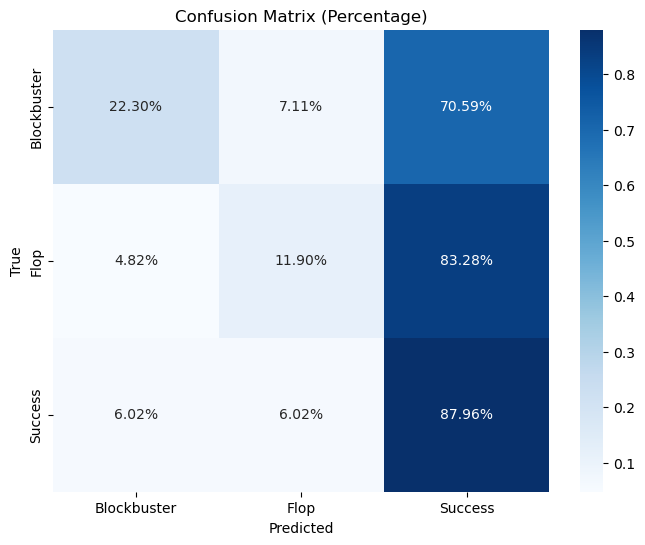

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
#y_pred = logreg.predict(X_test_with_features)

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row sum

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Blockbuster', 'Flop', 'Success'], 
            yticklabels=['Blockbuster', 'Flop', 'Success'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()

In [ ]:
print(Y_test)

In [61]:
# Define a mapping
from sklearn.preprocessing import label_binarize
label_mapping = {'Flop': 0, 'Success': 1, 'Blockbuster': 2}

# Convert Y_test using the mapping
Y_test_numeric = Y_test.replace(label_mapping)

# Binarize the labels correctly
y_test_bin = label_binarize(Y_test_numeric.values.ravel(), classes=[0, 1, 2])
print(Y_test_numeric[:5])  # Should now be numeric (0, 1, or 2)
print(y_test_bin[:5])  # Should correctly have one "1" per row

   success_level
0              1
1              1
2              1
3              1
4              1
[[0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]]


In [63]:
print("Unique values in Y_test_numeric:", set(Y_test_numeric.values.ravel()))
print("First few rows of y_test_bin:\n", y_test_bin[:5])


Unique values in Y_test_numeric: {0, 1, 2}
First few rows of y_test_bin:
 [[0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]]


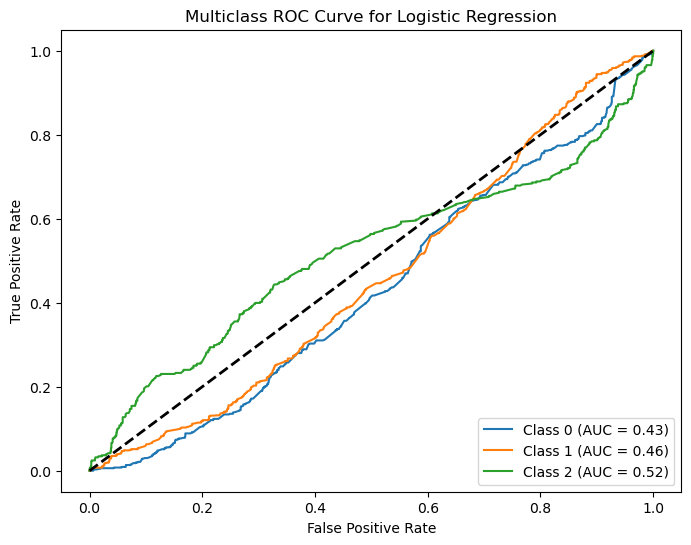

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have already defined X_test_numeric_scaled, Y_test, and have the correct preprocessed dataset

# Step 1: Train a logistic regression model
#logreg = LogisticRegression(max_iter=1000, multi_class='ovr', solver='lbfgs')  # Multi-class, one-vs-rest
#logreg.fit(X_test_numeric_scaled, Y_test.values.ravel())  # Fit the model with the scaled data

# Step 2: Binarize the labels
n_classes = len(set(Y_test.values.ravel()))  # Number of unique classes
#y_test_bin = label_binarize(Y_test.values.ravel(), classes=[0, 1, 2])  # Binary format for each class

# Step 3: Get predicted probabilities
y_probs = best_model.predict_proba(X_test_numeric_scaled)  # Predicted probabilities for each class

# Step 4: Plot the ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])  # Compute ROC curve for each class
    roc_auc = auc(fpr, tpr)  # Calculate AUC for each class
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Step 5: Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Step 6: Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()


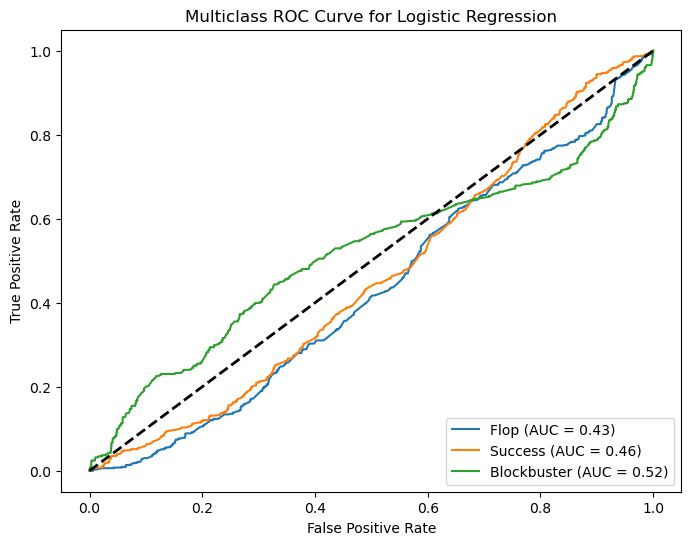

In [69]:
label_mapping = {'Flop': 0, 'Success': 1, 'Blockbuster': 2}
inv_label_mapping = {v: k for k, v in label_mapping.items()}  # Reverse the mapping

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    class_name = inv_label_mapping[i]  # Get class name from mapping
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()


In [ ]:
print(y_test_bin[:5])

In [ ]:
print(y_probs[:5]) 

In [ ]:
logreg.fit(X_numeric_scaled, Y.values.ravel())

In [77]:
from sklearn.metrics import f1_score
f1_per_class = f1_score(Y_test, y_pred, average=None)
print("F1 Score per class:", f1_per_class)
f1_micro = f1_score(Y_test, y_pred, average='micro')
print("Micro F1 Score:", f1_micro)

F1 Score per class: [0.31818182 0.19434194 0.56482791]
Micro F1 Score: 0.43867655447803766
